# Forest: Tree crown detection

## Context
### Purpose
Detect tree crown using state-of-art models

### Modelling approach
A prebuilt Deep Learning model, named _DeepForest_, is used to predict individual tree crowns from an airborne RGB image. _DeepForest_ was trained on data from the National Ecological Observatory Network (NEON). _DeepForest_ was implemented in Python 3.7 using initally Tensorflow v1.14 but later moved to Pytorch. Further details can be found in the [package documentation](https://deepforest.readthedocs.io/en/latest/).

### Highlights
* Fetch and load a NEON image from a Zenodo repository using `intake` and `dask`.
* Retrieve and plot the ground-truth annotations (bounding boxes) for the target image.
* Load and use a pretrained _DeepForest_ model to generate predictions from the full-image or tile-wise prediction.
* Indicate the pros and cons of full-image and tile-wise prediction.

### Authors
Alejandro Coca-Castro, The Alan Turing Institute, [@acocac](https://github.com/acocac)

### Reviewers
Matt Allen, Department of Geography - University of Cambridge, [@mja2106](https://github.com/mja2106), 16/09/21 (latest revision)

:::{note}
The author acknowledges [DeepForest](https://deepforest.readthedocs.io/en/latest/) contributors. Some code snippets were extracted from DeepForest [GitHub public repository](https://github.com/weecology/DeepForest).
:::

## Install and load libraries

In [10]:
!pip -q install git+https://github.com/ESM-VFC/intake_zenodo_fetcher.git ##Intake Zenodo Fetcher
!pip -q install pycurl
!pip -q install DeepForest

In [43]:
import glob
import os
import urllib
import numpy as np

import intake
from intake_zenodo_fetcher import download_zenodo_files_for_entry
import matplotlib.pyplot as plt
import xmltodict
import cv2

import tempfile

import torch

%matplotlib inline

## Fetch a RGB image from Zenodo
Fetch a sample image from a publically accessible location.

In [7]:
# create a temp dir
path = tempfile.mkdtemp()

catalog_file = os.path.join(path, 'catalog.yaml')

with open(catalog_file, 'w') as f:
    f.write('''
sources:
  NEONTREE_rgb:
    driver: xarray_image
    description: 'NeonTreeEvaluation RGB images (collection)'
    metadata:
      zenodo_doi: "10.5281/zenodo.3459803"
    args:
      urlpath: "{{ CATALOG_DIR }}/NEONsample_RGB/2018_MLBS_3_541000_4140000_image_crop.tif"
      ''')

Load an intake catalog for the downloaded data

In [8]:
cat_tc = intake.open_catalog(catalog_file)

In [9]:
for catalog_entry in list(cat_tc):
    download_zenodo_files_for_entry(
        cat_tc[catalog_entry],
        force_download=False
    )

will download https://zenodo.org/api/files/5b372ed9-e4ec-41b0-a652-f0ce7d760e60/2018_MLBS_3_541000_4140000_image_crop.tif to /var/folders/l8/99_59fvn4bl2szm125grkgqw0000gr/T/tmp2l0u8qhk/NEONsample_RGB/2018_MLBS_3_541000_4140000_image_crop.tif


  0%|          | 0.00/100 [00:00<?, ?B/s]

## Load sample image

Here we use `intake` to load the image through `dask`.

In [11]:
tc_rgb = cat_tc["NEONTREE_rgb"].to_dask()

/Users/acoca/anaconda3/envs/envai-book/lib/python3.8/site-packages/intake_xarray/image.py:337: FutureWarning: open_files is deprecated and will be removed in a future release. Please use fsspec.core.open_files instead.
  files = open_files(self.urlpath, **self.storage_options)
/Users/acoca/anaconda3/envs/envai-book/lib/python3.8/site-packages/xarray/core/dataset.py:2145: FutureWarning: None value for 'chunks' is deprecated. It will raise an error in the future. Use instead '{}'
  warnings.warn(


In [12]:
tc_rgb

<xarray.DataArray (y: 1864, x: 1429, channel: 3)>
dask.array<xarray-<this-array>, shape=(1864, 1429, 3), dtype=uint8, chunksize=(1864, 1429, 3), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) int64 0 1 2 3 4 5 6 7 ... 1857 1858 1859 1860 1861 1862 1863
  * x        (x) int64 0 1 2 3 4 5 6 7 ... 1422 1423 1424 1425 1426 1427 1428
  * channel  (channel) int64 0 1 2

## Load and prepare labels

In [13]:
filenames = glob.glob(os.path.join(path, './NEONsample_RGB/*.tif'))
filesn = [os.path.basename(i) for i in filenames]

In [14]:
##Create ordered dictionary of .xml annotation files
def loadxml(imagename):
  imagename = imagename.replace('.tif','')
  fullurl = "https://raw.githubusercontent.com/weecology/NeonTreeEvaluation/master/annotations/" + imagename + ".xml"
  file = urllib.request.urlopen(fullurl)
  data = file.read()
  file.close()
  data = xmltodict.parse(data)
  return data

allxml = [loadxml(i) for i in filesn]

In [15]:
# function to extract bounding boxes
def extractbb(i):
  bb = [f['bndbox'] for f in allxml[i]['annotation']['object']]
  return bb

bball = [extractbb(i) for i in range(0,len(allxml))]
print(len(bball))

1


## Visualise image and labels

In [20]:
# function to plot images
def cv2_imshow(a, **kwargs):
    a = a.clip(0, 255).astype('uint8')
    # cv2 stores colors as BGR; convert to RGB
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)

    return plt.imshow(a, **kwargs)

In [21]:
image = tc_rgb

In [24]:
# plot predicted bbox
image2 = image.values.copy()
target_bbox = bball[0]
print(type(target_bbox))
print(target_bbox[0:2])

<class 'list'>
[OrderedDict([('xmin', '1377'), ('ymin', '697'), ('xmax', '1429'), ('ymax', '752')]), OrderedDict([('xmin', '787'), ('ymin', '232'), ('xmax', '811'), ('ymax', '256')])]


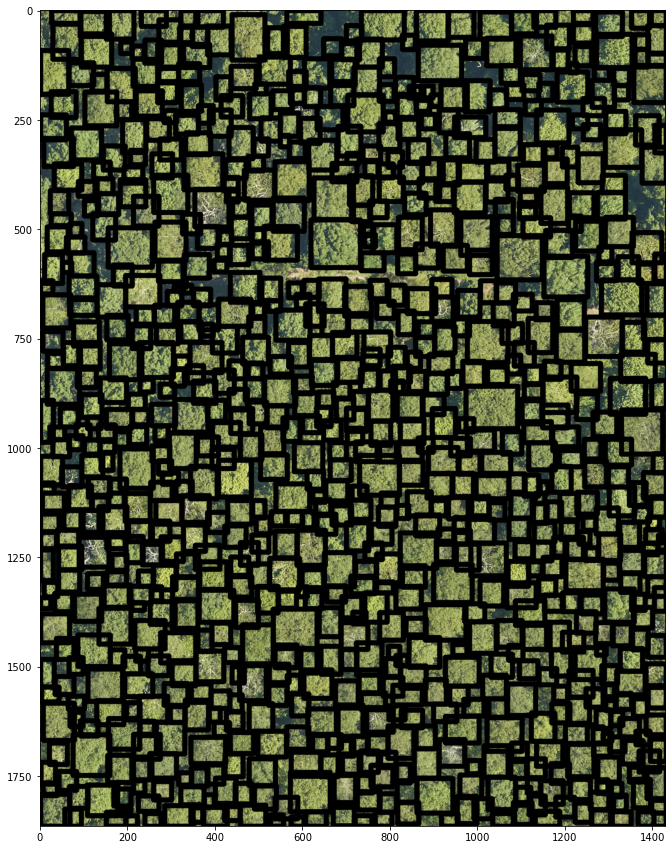

In [45]:
for row in target_bbox:
    cv2.rectangle(image2, (int(row["xmin"]), int(row["ymin"])), (int(row["xmax"]), int(row["ymax"])), (0, 0, 0), thickness=10, lineType=cv2.LINE_AA)

plt.figure(figsize=(15,15))
cv2_imshow(np.flip(image2,2))
plt.show()

## Load *DeepForest* pretrained model

Now we're going to load and use a pretrained model from the `deepforest` package.

In [26]:
from deepforest import main

In [44]:
# load deep forest model
model = main.deepforest()
model.use_release()
model.current_device = torch.device("cpu")

Reading config file: /Users/acoca/anaconda3/envs/envai-book/lib/python3.8/site-packages/deepforest/data/deepforest_config.yml
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


In [29]:
pred_boxes = model.predict_image(image=image.values)
print(pred_boxes.head(5))

/Users/acoca/anaconda3/envs/envai-book/lib/python3.8/site-packages/deepforest/predict.py:32: UserWarning: Image type is {}, transforming to float32. This assumes that the range of pixel values is 0-255, as opposed to 0-1.To suppress this warning, transform image (image.astype('float32')
  warnings.warn("Image type is {}, transforming to float32. This assumes that the range of pixel values is 0-255, as opposed to 0-1.To suppress this warning, transform image (image.astype('float32')")


     xmin   ymin    xmax   ymax label     score
0  1258.0  561.0  1399.0  698.0  Tree  0.415253
1  1119.0  527.0  1255.0  660.0  Tree  0.395937
2     7.0  248.0   140.0  395.0  Tree  0.376462
3   444.0  459.0   575.0  582.0  Tree  0.355283
4    94.0  149.0   208.0  260.0  Tree  0.347175


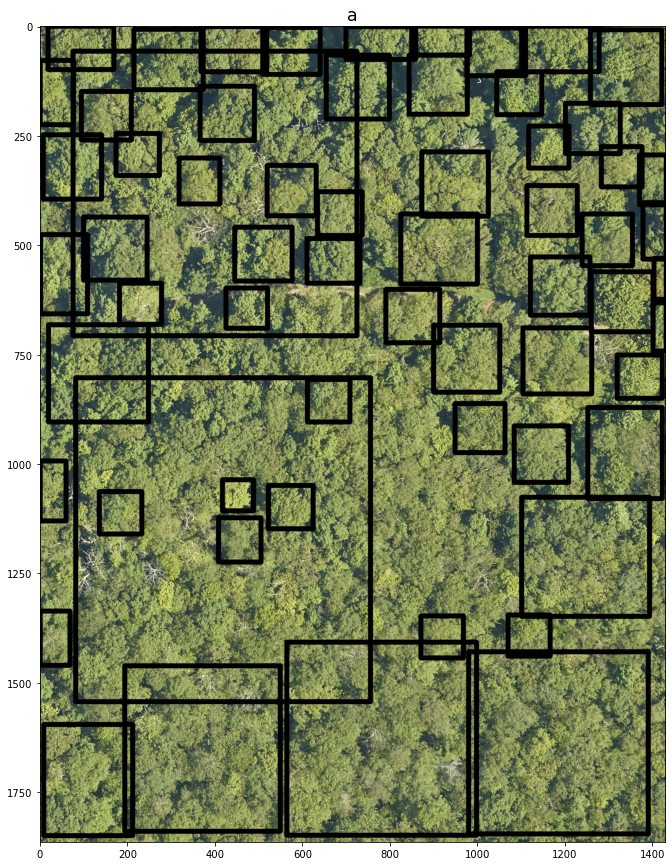

In [35]:
image3 = image.values.copy()

for index, row in pred_boxes.iterrows():
    cv2.rectangle(image3, (int(row["xmin"]), int(row["ymin"])), (int(row["xmax"]), int(row["ymax"])), (0, 0, 0), thickness=10, lineType=cv2.LINE_AA)

plt.figure(figsize=(15,15))
cv2_imshow(np.flip(image3,2))
plt.show()

## Comparison full image prediction and reference labels
Let's compare the labels and predictions over the tested image

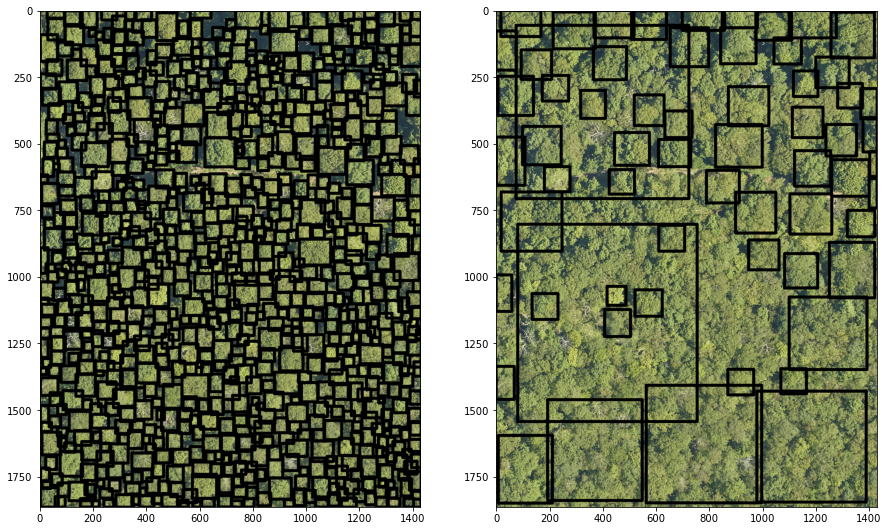

In [41]:
fig = plt.figure(figsize=(15,15))
ax1 = plt.subplot(1, 2, 1), cv2_imshow(np.flip(image2,2))
ax2 = plt.subplot(1, 2, 2), cv2_imshow(np.flip(image3,2))
plt.show() # To show figure

**Interpretation:**
*   It seems the pretrained model doesn't perform well with the tested image
*   The low performance might be explained due to the pretrained model used 10cm resolution images

## Tile-based prediction
To optimise the predictions, the DeepForest can be run [tile-wise](https://deepforest.readthedocs.io/en/latest/better.html)

The following cells show how to define the optimal window i.e. tile size.

In [22]:
from deepforest import preprocess

#Create windows of 400px
windows = preprocess.compute_windows(image.values, patch_size=400,patch_overlap=0)
print(f'We have {len(windows)} in the image')

We have 20 in the image


/Users/acoca/anaconda3/envs/envai-book/lib/python3.8/site-packages/deepforest/predict.py:32: UserWarning: Image type is {}, transforming to float32. This assumes that the range of pixel values is 0-255, as opposed to 0-1.To suppress this warning, transform image (image.astype('float32')
  warnings.warn("Image type is {}, transforming to float32. This assumes that the range of pixel values is 0-255, as opposed to 0-1.To suppress this warning, transform image (image.astype('float32')")


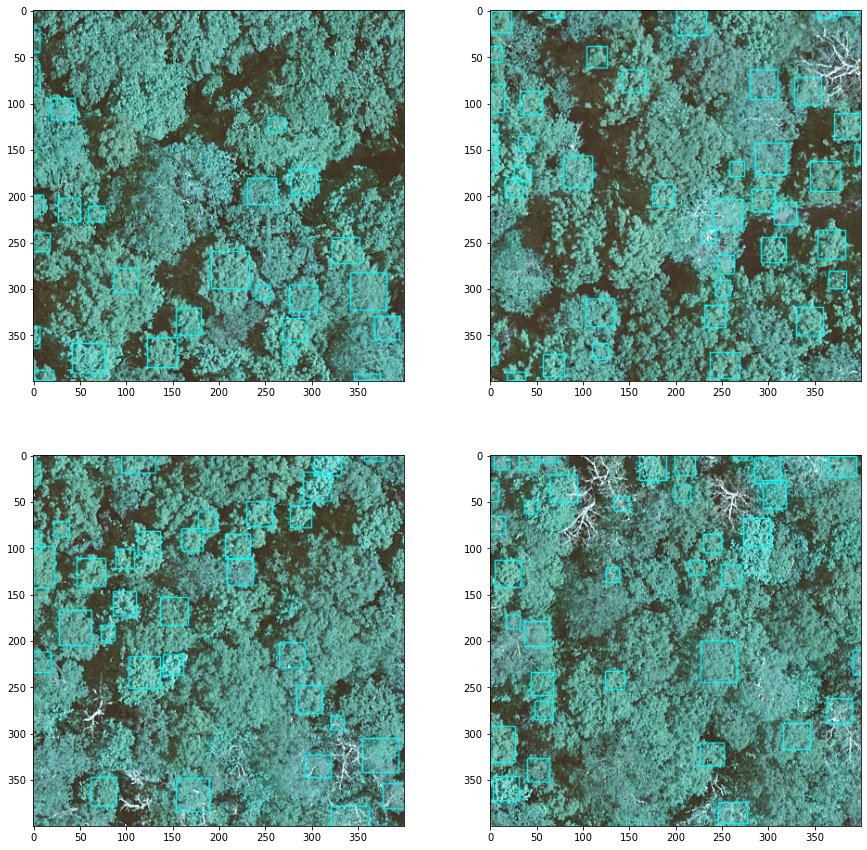

In [23]:
#Loop through a few sample windows, crop and predict
fig, axes, = plt.subplots(nrows=2,ncols=2, figsize=(15,15))
axes = axes.flatten()
for index2 in range(4):
    crop = image.values[windows[index2].indices()]
    #predict in bgr channel order, color predictions in red.
    boxes = model.predict_image(image=crop[...,::-1], return_plot = True)

    #but plot in rgb channel order
    axes[index2].imshow(boxes[...,::-1])

Once a suitable tile size is defined, we can run in a batch using the `predict_tile` function:

100%|██████████| 20/20 [00:49<00:00,  2.48s/it]


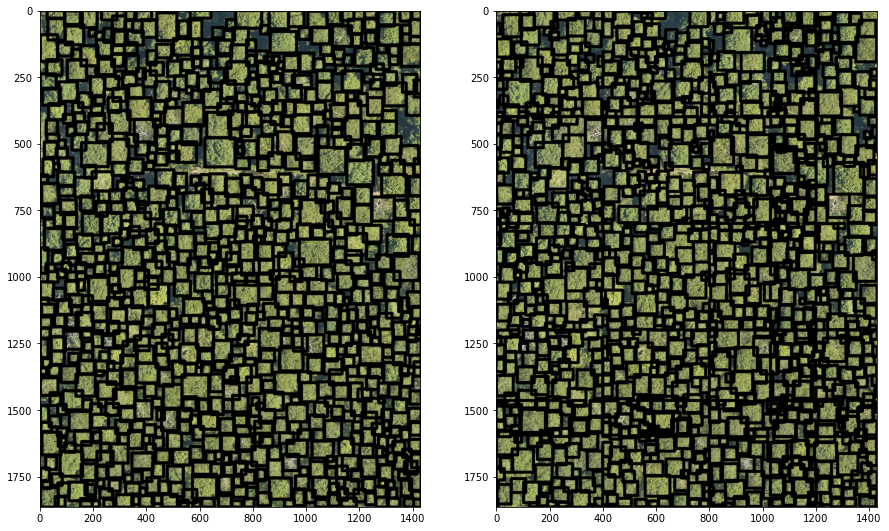

In [49]:
tile = model.predict_tile(image=image.values,return_plot=False,patch_overlap=0,iou_threshold=0.05,patch_size=400)

# plot predicted bbox
image_tile = image.values.copy()

for index, row in tile.iterrows():
    cv2.rectangle(image_tile, (int(row["xmin"]), int(row["ymin"])), (int(row["xmax"]), int(row["ymax"])), (0, 0, 0), thickness=10, lineType=cv2.LINE_AA)

fig = plt.figure(figsize=(15,15))
ax1 = plt.subplot(1, 2, 1), cv2_imshow(np.flip(image2,2))
ax2 = plt.subplot(1, 2, 2), cv2_imshow(np.flip(image_tile,2))
plt.show() # To show figure

**Interpretation**
* The tile-based prediction provides more reasonable results than predicting over the whole image
* While the prediction looks closer to the ground truth labels, there seem to be some tiles edges artefacts. This will require further investigation i.e. optimising the `deepforest` model which is out of the aims of this notebook

## Summary

This notebook has demonstrated the use of:
 - The `deepforest` package to easily load and run a pretrained model for tree crown classification from very-high resolution RGB imagery.
 -  `tile-wise` to considerably improve the prediction. However, user should define an optimal tile size.
 - `cv2` to visualise the bounding box.